# Chapter 5: The Many Variables & The Spurious Waffles - Samples

In [3]:
import pathlib
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
from matplotlib import pyplot as plt
from scipy import stats
import daft
from causalgraphicalmodels import CausalGraphicalModel
from aesara import shared
from rethinking import standardize, precis, DATA_PATH

### Code 5.1

**Spurious Association**

In [4]:
d = pd.read_csv(DATA_PATH.joinpath('WaffleDivorce.csv'), sep=';')
d['A'] = standardize(d['MedianAgeMarriage'])
d['D'] = standardize(d['Divorce'])
d['M'] = standardize(d['Marriage'])

### Code 5.2

We can do linear regression with `MedianAgeMarriage` as a predictor. The model could be:

$$D_i \sim \text{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta_AA_i$$
$$\alpha \sim \text{Normal}(0, 0.2)$$
$$\beta_A \sim \text{Normal}(0, 0.5)$$
$$\sigma \sim \text{Exponential}(1)$$

To understand what does the prior $\beta_A$ imply, if it is equal to 1, it would change one standard deviation.

In [5]:
d['MedianAgeMarriage'].std()

1.2436303013880823

### Code 5.3

Computing the approximate posterior.

In [6]:
with pm.Model() as m5_1:
    sigma = pm.Exponential('sigma', 1)
    bA = pm.Normal('bA', mu=0, sigma=0.5)
    a = pm.Normal('a', mu=0, sigma=0.2)
    mu = pm.Deterministic('mu', a + bA*d['A'].values)
    D = pm.Normal('D', mu=mu, sigma=sigma, observed=d['D'].values)
    prior_samples = pm.sample_prior_predictive(return_inferencedata=False, samples=50)
    trace5_1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


### Code 5.4

Plotting the different lines.

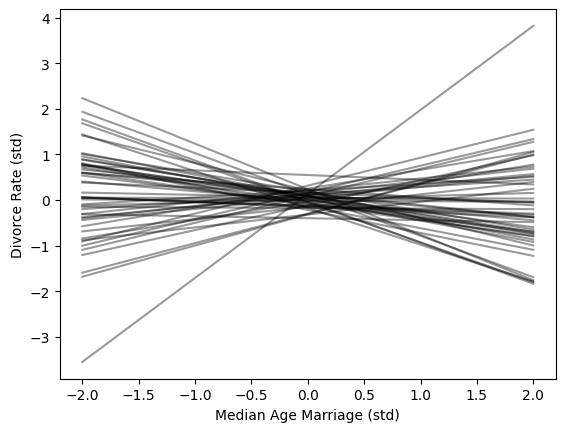

In [7]:
x_s = np.linspace(-2, 2, 50)
alpha_s = prior_samples['a']
bA_s = prior_samples['bA']

data = alpha_s[:,  np.newaxis] + (bA_s[:, np.newaxis] * np.tile(x_s, (50, 1)))

for line in data:
    plt.plot(x_s, line, 'black', alpha=0.4)
    
plt.xlabel("Median Age Marriage (std)")
plt.ylabel("Divorce Rate (std)");

### Code 5.5

Now compute the posterior predictions.

In [8]:
# compute percentile interval of mean
mean_q = pm.find_MAP(model=m5_1)
H = pm.find_hessian(mean_q, model=m5_1)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[v.name]) for v in [a, bA, sigma]])
posterior = stats.multivariate_normal(mean=mean, cov=cov)

In [9]:
A_seq = np.linspace(-3, 3.2, 30)
post = posterior.rvs(10_000)

mu = post[:, 0:1] + (post[:, 1:2] * np.tile(A_seq, (10_000, 1)))
sigmas = np.tile(post[:, 2], (30, 1)).T
posterior_sample = np.random.normal(loc=mu, scale=sigmas, size=(10_000, 30))

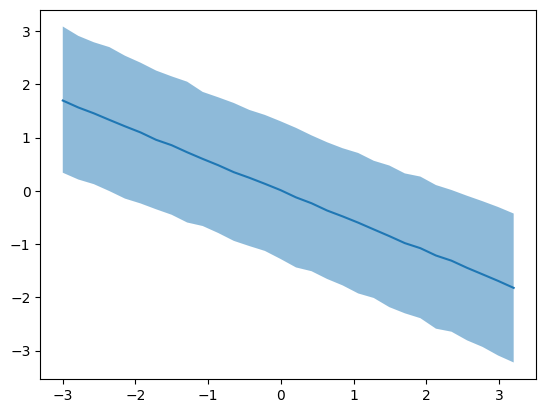

In [10]:
post_mean = posterior_sample.mean(axis=0)
post_pi = np.array([np.quantile(m, [0.055, 0.945]) for m in posterior_sample.T])
plt.plot(A_seq, post_mean);
plt.fill_between(A_seq, post_pi[:, 0], post_pi[:, 1], alpha=0.5);

### Code 5.6

You can fit the Marriage Rate as well.

In [11]:
with pm.Model() as m5_2:
    sigma = pm.Exponential('sigma', 1)
    bM = pm.Normal('bM', mu=0, sigma=0.5)
    a = pm.Normal('a', mu=0, sigma=0.2)
    mu = pm.Deterministic('mu', a + bM*d['M'].values)
    D = pm.Normal('D', mu=mu, sigma=sigma, observed=d['D'].values)
    trace5_2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


### Code 5.7

Drawing a DAG

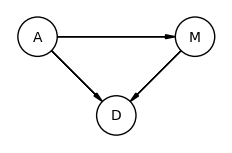

In [12]:
dag5_1 = CausalGraphicalModel(nodes=['A', 'D', 'M'], edges=[('A', 'D'), ('A', 'M'), ('M', 'D')])
pgm = daft.PGM()
coordinates = {'A': (0, 0), 'D': (1, 1), 'M': (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis();

### Code 5.8

Define the second DAG and display the implied conditional independencies.

[('D', 'M', {'A'})]


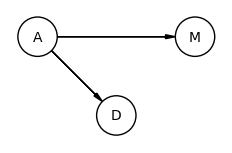

In [13]:
dag5_2 = CausalGraphicalModel(nodes=['A', 'D', 'M'], edges=[('A', 'D'), ('A', 'M')])
pgm = daft.PGM()
coordinates = {'A': (0, 0), 'D': (1, 1), 'M': (2, 0)}
for node in dag5_2.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_2.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis();

print(dag5_2.get_all_independence_relationships())

### Code 5.9

The first DAG has no conditional independencies, you can define it and check.

In [14]:
print(dag5_1.get_all_independence_relationships())

[]


### Code 5.10

To see the differences when we add another variable, we can fit to both.

In [15]:
with pm.Model() as m5_3:
    a = pm.Normal('a', 0, 0.2)
    bA = pm.Normal('bA', 0, 0.5)
    bM = pm.Normal('bM', 0, 0.5)

    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + bM * d['M'].values + bA * d['A'].values)

    div = pm.Normal(
        'div', mu=mu, sigma=sigma, observed=d['D'].values
    )
    trace5_3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


### Code 5.11

Plot the coefficients

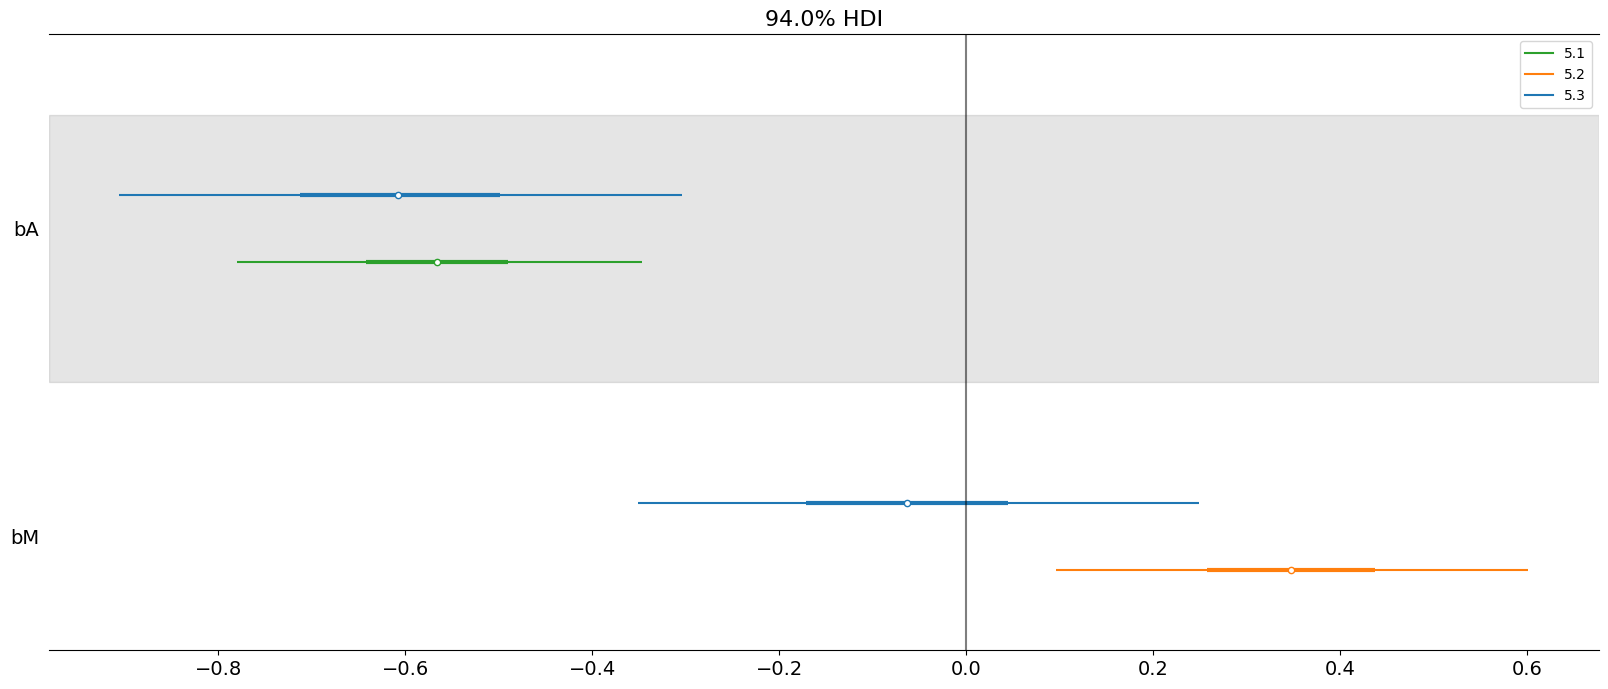

In [16]:
az.plot_forest(
    [trace5_3, trace5_2, trace5_1],
    model_names=['5.3', '5.2', '5.1'],
    var_names=['bA', 'bM'],
    combined=True, figsize=(20,8));
plt.axvline(0, color='black', alpha=0.5);

### Code 5.12

Simulating the divorce example

In [17]:
N = 50
age = np.random.normal(size=50)
mar = np.random.normal(size=50, loc=-age)
div = np.random.normal(size=50, loc=age)

### Code 5.13

**Predictor residual plots**

In [18]:
with pm.Model() as m5_4:
    sigma = pm.Exponential('sigma', 1)
    bAM = pm.Normal('bAM', 0, 0.5)
    a = pm.Normal('a', 0, 0.2)
    mu = pm.Deterministic('mu', a + bAM * d['A'].values)
    M = pm.Normal('M', mu, sigma, observed=d['D'].values)
    trace5_4 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bAM, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


### Code 5.14

Generate residuals.

In [19]:
mu_mean = trace5_4.posterior['mu'].mean(dim=["chain", "draw"])
mu_residuals = d['M'] - mu_mean

### Code 5.15

Simulate predictions, avering over the posterior.

In [20]:
# call link without specifying new data
# so it uses original data

m5_3_pcc = pm.sample_posterior_predictive(trace5_3, var_names=['mu', 'div'], model=m5_3)

# summarize samples across cases
mu_mean = m5_3_pcc.posterior_predictive['mu'].mean(dim=['chain', 'draw'])
mu_PI = az.hdi(m5_3_pcc.posterior_predictive['mu'], 0.89)

# simulate observations
# again no new data, so uses original data

D_sim = m5_3_pcc.posterior_predictive['div'].mean(dim=['chain', 'draw'])
D_PI = az.hdi(m5_3_pcc.posterior_predictive['div'], 0.89)

### Code 5.16

Display the simulations.

<ErrorbarContainer object of 3 artists>

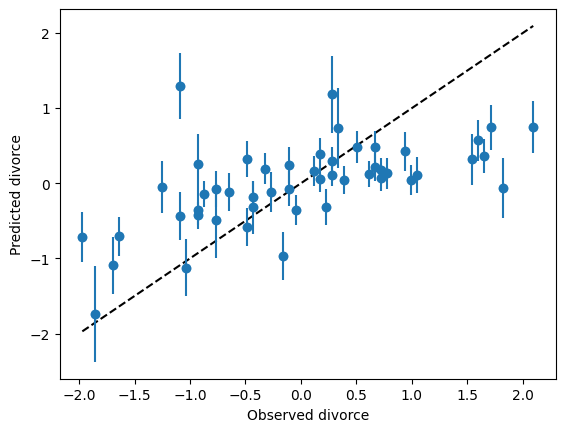

In [21]:
plt.plot(d['D'], mu_mean, 'o', alpha=0.5)
plt.xlabel('Observed divorce')
plt.ylabel('Predicted divorce')

min_x, max_x = d['D'].min(), d['D'].max()
plt.plot([min_x, max_x], [min_x, max_x], "k--")


plt.errorbar(d['D'], mu_mean,
    yerr=np.abs(np.array(D_sim) - mu_PI.min(dim="hdi").to_array()),
    fmt="C0o",
)

### Code 5.17

Matplotlib doesn't allow labeling manually.

### Code 5.18

Simulating sperious association.

In [22]:
N = 100
x_real = np.random.normal(size=N)
x_spur = np.random.normal(size=N, loc=x_real)
y = np.random.normal(size=N, loc=x_real)
dataframe = pd.DataFrame([y, x_real, x_spur]).T
dataframe.head()

,0,1,2
0,-0.079006,-0.084438,0.630353
1,-1.587797,-0.792647,-1.946731
2,-1.880763,-1.360618,-1.871479
3,1.599649,1.075354,1.151286
4,0.737801,-0.548391,-0.214361


### Code 5.19

To estimate the influence of A on M, all we need is to regress A on M. There are no other variables in the DAG creating an association between A and M.

In [23]:
d = pd.read_csv(DATA_PATH.joinpath('WaffleDivorce.csv'), sep=';')
d['A'] = standardize(d['MedianAgeMarriage'])
d['D'] = standardize(d['Divorce'])
d['M'] = standardize(d['Marriage'])

# Use Aesara shared variables so we can change them later
marriage_shared = shared(d['M'].values)
age_shared = shared(d['A'].values)

with pm.Model() as m5_3A:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bA * age_shared + bM * marriage_shared)
    divorce = pm.Normal("divorce", mu, sigma, observed=d['D'].values)

    # A -> M
    sigma_M = pm.Exponential("sigma_m", 1)
    bAM = pm.Normal("bAM", 0, 0.5)
    aM = pm.Normal("aM", 0, 0.2)
    mu_M = pm.Deterministic("mu_m", aM + bAM * age_shared)
    marriage = pm.Normal("marriage", mu_M, sigma_M, observed=d['M'].values)

    trace5_3A = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, bM, a, sigma_m, bAM, aM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


### Code 5.20

The goal is to simulate what would happen if we manipulate A.

In [24]:
# We're setting this to 50 to match the shape of our input
A_seq = np.linspace(-2, 2, 50)
A_seq.shape

(50,)

### Code 5.21

We have to simulate the influence of A on M before we simulate the joint influence of A and M on D.

In [25]:
# With PyMC we have to simulate in each model separately

# Simulate the marriage rates at each age first
age_shared.set_value(A_seq)
m5_3A_marriage = pm.sample_posterior_predictive(trace5_3A, model=m5_3A)

### Code 5.22

Plot the predictions.

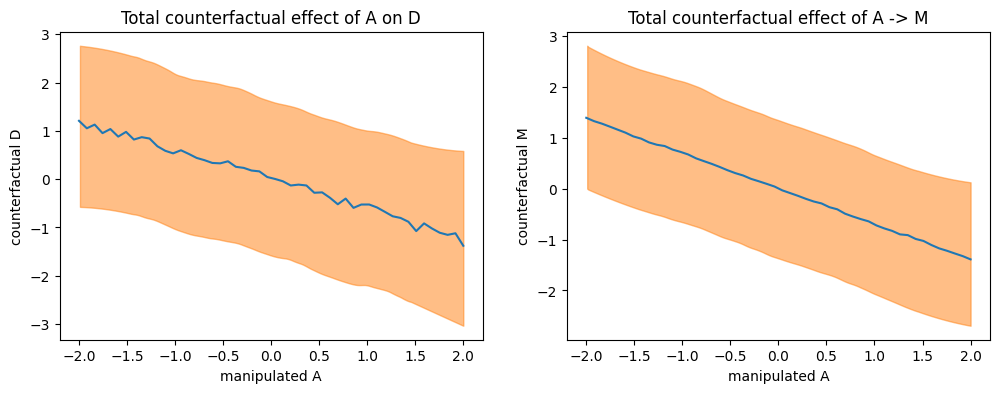

In [26]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
az.plot_hdi(A_seq, m5_3A_marriage.posterior_predictive["divorce"], ax=ax[0])
ax[0].plot(A_seq, m5_3A_marriage.posterior_predictive["divorce"].mean(dim=["chain", "draw"]))
ax[0].set_title("Total counterfactual effect of A on D")
ax[0].set_xlabel("manipulated A")
ax[0].set_ylabel("counterfactual D")


az.plot_hdi(A_seq, m5_3A_marriage.posterior_predictive["marriage"], ax=ax[1])
ax[1].plot(A_seq, m5_3A_marriage.posterior_predictive["marriage"].mean(dim=["chain", "draw"]))
ax[1].set_title("Total counterfactual effect of A -> M")
ax[1].set_xlabel("manipulated A")
ax[1].set_ylabel("counterfactual M");

### Code 5.23

Calculate the expected causal effect of increasing median age at marriage from 20 to 30.

In [27]:
# We're setting this to 50 to match the shape of our input
A_seq = (np.linspace(20, 30, 50) - 26.1) / 1.24

age_shared.set_value(A_seq)

m5_3_M_ppc = pm.sample_posterior_predictive(trace5_3A, model=m5_3A)

# Average first and last column and take difference
(
    m5_3_M_ppc.posterior_predictive["divorce"][:, -1].mean()
    - m5_3_M_ppc.posterior_predictive["divorce"][:, 0].mean()
)

<xarray.DataArray 'divorce' ()>
array(-0.25104147)

### Code 5.24

If we control the values of M, then A no longer influences it. It's a perfectly controlled experiment. Modify the code above to simulate the counterfactual result of manipulating M.

(-5.0, 5.0)

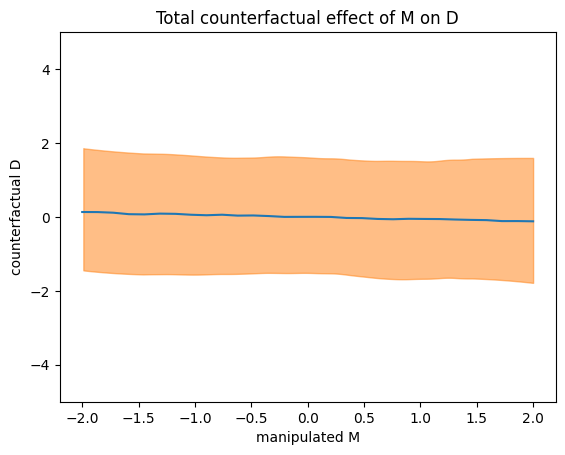

In [28]:
sim_dat = pd.DataFrame({'M': np.linspace(-2, 2, 30), 'A': np.repeat(0, 30)})
age_shared.set_value(sim_dat['A'])
marriage_shared.set_value(sim_dat['M'])

s = pm.sample_posterior_predictive(trace5_3A, model=m5_3A)

_, ax = plt.subplots(1, 1)
az.plot_hdi(sim_dat['M'], s.posterior_predictive["divorce"], ax=ax)
ax.plot(sim_dat['M'], s.posterior_predictive["divorce"].mean(dim=["chain", "draw"]))
ax.set_title("Total counterfactual effect of M on D")
ax.set_xlabel("manipulated M")
ax.set_ylabel("counterfactual D");
ax.set_ylim([-5, 5])

### Code 5.25 & 5.26 & 5.27

Simualting counterfactuals manually.

In [29]:
with pm.Model() as m5_3A:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bA * d['A'].values + bM * d['M'].values)
    divorce = pm.Normal("divorce", mu, sigma, observed=d['D'].values)

    # A -> M
    sigma_M = pm.Exponential("sigma_m", 1)
    bAM = pm.Normal("bAM", 0, 0.5)
    aM = pm.Normal("aM", 0, 0.2)
    mu_M = pm.Deterministic("mu_m", aM + bAM * d['A'].values)
    marriage = pm.Normal("marriage", mu_M, sigma_M, observed=d['M'].values)
    

# Extract the variable names
vars_ = [bA, bM, a, sigma, aM, bAM, sigma_M]
var_names = [v.name for v in vars_]

mean_q = pm.find_MAP(model=m5_3A)
H = pm.find_hessian(mean_q, vars_, model=m5_3A)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[var_]) for var_ in var_names])
posterior = stats.multivariate_normal(mean=mean, cov=cov)

In [30]:
n_simulations = 30
A_seq = np.linspace(-2, 2, n_simulations)

post = pd.DataFrame(posterior.rvs(size=1_000), columns=var_names)

mus = post[['aM']].to_numpy() + post[['bAM']].to_numpy() * np.tile(A_seq, (1_000, 1))
sigmas = np.tile(post['sigma_m'], (n_simulations, 1)).T

M_sim = np.random.normal(
    size=(1_000, n_simulations),
    loc=mus,
    scale=sigmas
)

hdis = np.array([az.hdi(sim, 0.89) for sim in M_sim.T])

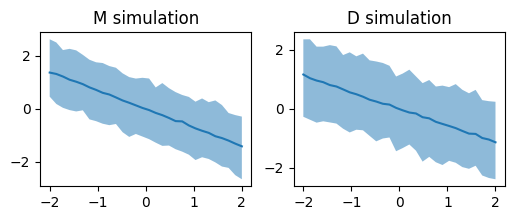

In [31]:
sigmas = np.tile(post['sigma'], (n_simulations, 1)).T
mus = post[['a']].to_numpy() + post[['bA']].to_numpy() * np.tile(A_seq, (1_000, 1)) + post[['bM']].to_numpy() * M_sim

D_sim = np.random.normal(
    size=(1_000, n_simulations),
    loc=mus,
    scale=sigmas
)

hdisD = np.array([az.hdi(sim, 0.89) for sim in D_sim.T])

plt.figure(figsize=(6,2))
plt.subplot(1, 2, 1)
plt.title('M simulation')
plt.plot(A_seq, M_sim.mean(axis=0))
plt.fill_between(A_seq, hdis[:, 0], hdis[:, 1], alpha=0.5)


plt.subplot(1, 2, 2)
plt.plot(A_seq, D_sim.mean(axis=0))
plt.title('D simulation')
plt.fill_between(A_seq, hdisD[:, 0], hdisD[:, 1], alpha=0.5);

**Masked relationship**

We have seen that using multiple predictor variables is useful to find spurious relationships. Another reason to use multiple variables is to find the direct influence of multiple factors on an outcome.

### Code 5.28

Let's consider a new data context. Let's load the data.

In [32]:
d = pd.read_csv(DATA_PATH.joinpath('milk.csv'), sep=';')
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


> Hypothesis: Primates with larger brains produce more energetic milk, so that brains grow quickly.

We will find out to what extent energy content of milk, measured here in kilocalories, is related to the percent of the brain mass that is neocortex.

### Code 5.29

Standardizing helps us both get a reliable approximation of the posterior as well as build reasonable priors.

In [79]:
d['K'] = standardize(d['kcal.per.g'])
d['N'] = standardize(d['neocortex.perc'])
d['M'] = standardize(np.log(d['mass']))

The first model to consider is the simple bivariate regression between kilocalories and neocortex percent. In math:

$$K_i \sim \text{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta_NN_i$$

K is the standardized kilocalories and N is the standardized neocortex percent.

### Code 5.30

First let's run the model with vague priors.

In [34]:
with pm.Model() as m5_5:
    sigma = pm.Exponential('sigma', 1)
    bN = pm.Normal('bN', 0, 1)
    a = pm.Normal('a', 0, 1)
    mu = pm.Deterministic('mu', a + bN * d['N'].values)
    K = pm.Normal('K', mu, sigma, observed=d['K'].values)

try:
    mean_q = pm.find_MAP(model=m5_5)
except:
    print('The previous line has failed!')

The previous line has failed!


We had an error in the previous line, and the problem is because of the missing values in the $N$ variable.

### Code 5.31

Take a look inside the variable.

In [35]:
d['neocortex.perc'].head()

0    55.16
1      NaN
2      NaN
3      NaN
4      NaN
Name: neocortex.perc, dtype: float64

Our modeling isn't prepared to handle missing values. We need to drop all lines with $NaN$

This is known as a <span style="color:blue">COMPLETE CASE ANALYSIS</span>, where we need to drop all the cases with missing values.

### Code 5.32

We will drop any cases with missing values.

In [82]:
dcc = d.dropna(subset=['K', 'N', 'M'], how='any')

### Code 5.33

We can now run the same procedure but now with the `dcc` dataframe.

In [37]:
with pm.Model() as m5_5_draft:
    sigma = pm.Exponential('sigma', 1)
    bN = pm.Normal('bN', 0, 1)
    a = pm.Normal('a', 0, 1)
    mu = pm.Deterministic('mu', a + bN * dcc['N'].values)
    K = pm.Normal('K', mu, sigma, observed=dcc['K'].values)

# Extract the variable names
vars_ = [a, bN, sigma]
var_names = [v.name for v in vars_]

mean_q = pm.find_MAP(model=m5_5_draft)
H = pm.find_hessian(mean_q, vars_, model=m5_5_draft)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[var_]) for var_ in var_names])
posterior = stats.multivariate_normal(mean=mean, cov=cov)

### Code 5.34

Before considering the posterior predictions, let's consider the priors.

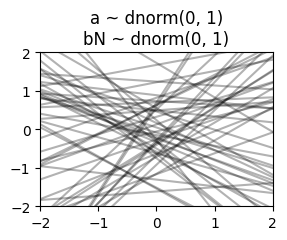

In [38]:
prior = pm.sample_prior_predictive(model=m5_5_draft, return_inferencedata=False, samples=50)
x_seq = np.array([[-2, 2]]).T
mu = prior['a'] + prior['bN'] * x_seq

plt.figure(figsize=(3, 2))
plt.xlim(x_seq)
plt.ylim(x_seq)
plt.title('a ~ dnorm(0, 1)\nbN ~ dnorm(0, 1)')
for i in range(50):
    plt.plot(x_seq, mu[:, i], color='black', alpha=0.3);

The prior is crazy, we can improve it a lot more.

### Code 5.35

When predictor is zero, the expected value should also be zero. And the slope $B_N$ doesn't get to be very big as well.

In [86]:
with pm.Model() as m5_5:
    sigma = pm.Exponential('sigma', 1)
    bN = pm.Normal('bN', 0, 0.5)
    a = pm.Normal('a', 0, 0.2)
    mu = pm.Deterministic('mu', a + bN * dcc['N'].values)
    K = pm.Normal('K', mu, sigma, observed=dcc['K'].values)

# Extract the variable names
vars_ = [a, bN, sigma]
var_names = [v.name for v in vars_]

mean_q = pm.find_MAP(model=m5_5)
H = pm.find_hessian(mean_q, vars_, model=m5_5)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[var_]) for var_ in var_names])
posterior = stats.multivariate_normal(mean=mean, cov=cov)

post55_data = pd.DataFrame(posterior.rvs(10_000), columns=var_names)

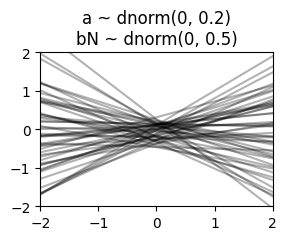

In [40]:
prior = pm.sample_prior_predictive(model=m5_5, return_inferencedata=False, samples=50)
x_seq = np.array([[-2, 2]]).T
mu = prior['a'] + prior['bN'] * x_seq

plt.figure(figsize=(3, 2))
plt.xlim(x_seq)
plt.ylim(x_seq)
plt.title('a ~ dnorm(0, 0.2)\nbN ~ dnorm(0, 0.5)')
for i in range(50):
    plt.plot(x_seq, mu[:, i], color='black', alpha=0.3);

Much better!

Let's get a summary of the posterior.

### Code 5.36

In [41]:
precis(posterior, var_names)

,mean,std,5.5%,94.5%
a,0.041191,0.152936,-0.200084,0.285950
bN,0.137257,0.221384,-0.218638,0.491602
sigma,0.997490,0.165143,0.729492,1.260361


This is not a strong or precise association. The stardard deviation is 2x the posterior mean.

### Code 5.37

We can plot to make it more visual.

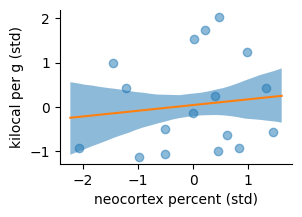

In [66]:
xseq = np.linspace(dcc['N'].min() - 0.15, dcc['N'].max() + 0.15, 30)

post = pd.DataFrame(posterior.rvs(size=1_000), columns=var_names)
mu = post[['a']].to_numpy() + post[['bN']].to_numpy() * np.tile(xseq, (1_000, 1))
mu_mean = mu.mean(axis=0)
mu_PI = np.array([np.quantile(m, [0.055, 0.945]) for m in mu.T])

# Plotting
plt.figure(figsize=(3, 2))
ax = plt.subplot()
plt.plot(dcc['N'], dcc['K'], 'o', alpha=0.5)
plt.plot(xseq, mu_mean)
plt.fill_between(xseq, mu_PI[:, 0], mu_PI[:, 1], alpha=0.5)
plt.xlabel('neocortex percent (std)')
plt.ylabel('kilocal per g (std)')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False);

### Code 5.38

Now we consider the bivariate relationship between kilocalories and body mass. Since body mass is also standardized, we can use the same priors and stay within possible outcome values.

In [87]:
with pm.Model() as m5_6:
    sigma = pm.Exponential('sigma', 1)
    bM = pm.Normal('bM', 0, 0.5)
    a = pm.Normal('a', 0, 0.2)
    mu = pm.Deterministic('mu', a + bM * dcc['M'].values)
    K = pm.Normal('K', mu, sigma, observed=dcc['K'].values)

# Extract the variable names
vars_ = [a, bM, sigma]
var_names = [v.name for v in vars_]

mean_q = pm.find_MAP(model=m5_6)
H = pm.find_hessian(mean_q, vars_, model=m5_6)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[var_]) for var_ in var_names])
posterior = stats.multivariate_normal(mean=mean, cov=cov)

post56_data = pd.DataFrame(posterior.rvs(10_000), columns=var_names)

precis(posterior, var_names)

,mean,std,5.5%,94.5%
a,0.047153,0.152526,-0.196970,0.292553
bM,-0.282323,0.193702,-0.592008,0.028458
sigma,0.950104,0.165094,0.685623,1.211226


Log-mass is negatively associated with kilocalories. This association seems stronger than neocortex percent, although in the opposite direction.

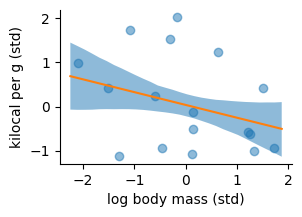

In [84]:
xseq = np.linspace(dcc['M'].min() - 0.15, dcc['M'].max() + 0.15, 30)

post = pd.DataFrame(posterior.rvs(size=1_000), columns=var_names)
mu = post[['a']].to_numpy() + post[['bM']].to_numpy() * np.tile(xseq, (1_000, 1))
mu_mean = mu.mean(axis=0)
mu_PI = np.array([np.quantile(m, [0.055, 0.945]) for m in mu.T])

# Plotting
plt.figure(figsize=(3, 2))
ax = plt.subplot()
plt.plot(dcc['M'], dcc['K'], 'o', alpha=0.5)
plt.plot(xseq, mu_mean)
plt.fill_between(xseq, mu_PI[:, 0], mu_PI[:, 1], alpha=0.5)
plt.xlabel('log body mass (std)')
plt.ylabel('kilocal per g (std)')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False);

### Code 5.39

Now let's see what happens if we add both predictor variables at the same time to the regression.

$$K_i \sim \text{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta_NN_i + \beta_MM_i$$
$$\alpha \sim \text{Normal}(0, 0.2)$$
$$\beta_N \sim \text{Normal}(0, 0.5)$$
$$\beta_M \sim \text{Normal}(0, 0.5)$$
$$\sigma \sim \text{Exponential}(1)$$

In [88]:
with pm.Model() as m5_7:
    sigma = pm.Exponential('sigma', 1)
    bM = pm.Normal('bM', 0, 0.5)
    bN = pm.Normal('bN', 0, 0.5)
    a = pm.Normal('a', 0, 0.2)
    mu = pm.Deterministic('mu', a + bM * dcc['M'].values + bN * dcc['N'].values)
    K = pm.Normal('K', mu, sigma, observed=dcc['K'].values)
    
# Extract the variable names
vars_ = [a, bM, bN, sigma]
var_names = [v.name for v in vars_]

mean_q = pm.find_MAP(model=m5_7)
H = pm.find_hessian(mean_q, vars_, model=m5_7)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[var_]) for var_ in var_names])
posterior = stats.multivariate_normal(mean=mean, cov=cov)

post57_data = pd.DataFrame(posterior.rvs(10_000), columns=var_names)

precis(posterior, var_names)

,mean,std,5.5%,94.5%
a,0.066904,0.134050,-0.149068,0.281120
bM,-0.704104,0.221598,-1.059255,-0.351205
bN,0.678116,0.250112,0.279006,1.077881
sigma,0.738746,0.181858,0.446524,1.028049


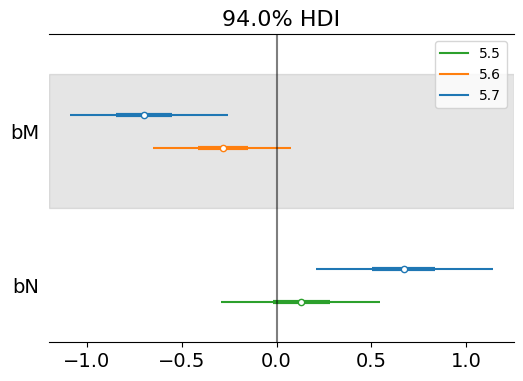

In [103]:
az.plot_forest(
    [
        post57_data.to_dict('list'),
        post56_data.to_dict('list'),
        post55_data.to_dict('list'),
    ],
    model_names=['5.7', '5.6', '5.5'],
    var_names=['bM', 'bN'],
    combined=True, figsize=(6, 4));
plt.axvline(0, color='black', alpha=0.5);

The posterior means for neocortex percent and log-mass have both moved away from zero. Both predictors seems to have made their estimates move apart.

Now to make counterfactual plot again.

### Code 5.41

Let's see how the model sees the association between each predictor and outcome.

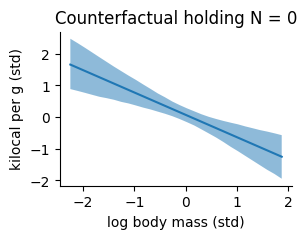

In [106]:
xseq = np.linspace(dcc['M'].min() - 0.15, dcc['M'].max() + 0.15, 30)
nseq = np.repeat(0, 30)

post = pd.DataFrame(posterior.rvs(size=1_000), columns=var_names)
mu = post[['a']].to_numpy() + post[['bM']].to_numpy() * np.tile(xseq, (1_000, 1)) + post[['bN']].to_numpy() * np.tile(nseq, (1_000, 1))
mu_mean = mu.mean(axis=0)
mu_PI = np.array([np.quantile(m, [0.055, 0.945]) for m in mu.T])

# Plotting
plt.figure(figsize=(3, 2))
ax = plt.subplot()
plt.plot(xseq, mu_mean)
plt.fill_between(xseq, mu_PI[:, 0], mu_PI[:, 1], alpha=0.5)
plt.title('Counterfactual holding N = 0')
plt.xlabel('log body mass (std)')
plt.ylabel('kilocal per g (std)')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False);

### Code 5.42 & 5.43

Simulate data in which two meaningful predictors act to mask one another.

In [113]:
# M -> K <- N
# M -> N
n = 100
M = np.random.normal(size=100)
N = np.random.normal(size=100, loc=M)
K = np.random.normal(size=100, loc=N-M)
d_sim = pd.DataFrame({'K': K, 'N': N, 'M': M})
d_sim.head()

,K,N,M
0,-1.793677,-0.388425,0.324718
1,-0.558285,-0.045282,0.668491
2,-0.865795,-3.040642,-2.039357
3,-1.211628,1.586228,0.935935
4,0.815628,1.404427,0.350158


In [110]:
# M -> K <- N
# N -> M
n = 100
N = np.random.normal(size=100)
M = np.random.normal(size=100, loc=N)
K = np.random.normal(size=100, loc=N-M)
d_sim2 = pd.DataFrame({'K': K, 'N': N, 'M': M})
d_sim2.head()

,K,N,M
0,0.736065,0.363085,0.476366
1,-1.024824,-1.806837,-1.022255
2,-0.642431,-1.583785,-1.736406
3,0.488811,1.739010,2.374499
4,0.384768,-0.322776,-0.556898


In [111]:
# M -> K <- N
# N <- U -> M
n = 100
U = np.random.normal(size=100)
M = np.random.normal(size=100, loc=U)
N = np.random.normal(size=100, loc=U)
K = np.random.normal(size=100, loc=N-M)
d_sim3 = pd.DataFrame({'K': K, 'N': N, 'M': M})
d_sim3.head()

,K,N,M
0,-2.172762,-0.314909,0.755933
1,-1.518575,1.643510,1.300667
2,1.672820,-0.571404,-1.042550
3,0.963096,1.675022,-0.345442
4,1.331018,0.603437,-2.076398


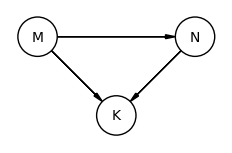

In [112]:
dag5_7 = CausalGraphicalModel(nodes=['M', 'K', 'N'], edges=[('M', 'K'), ('N', 'K'), ('M', 'N')])
pgm = daft.PGM()
coordinates = {'M': (0, 0), 'K': (1, 1), 'N': (2, 0)}
for node in dag5_7.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_7.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis();

### Code 5.44

**Binary Categories**

Take a look at the variables available

In [114]:
d = pd.read_csv(DATA_PATH.joinpath('Howell1.csv'), delimiter=";")
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


The male variable is our new predictor, an example of an <span style="color:blue">INDICATOR VARIABLE</span>.

### Code 5.46

We can include the male as a simple extra variable.

$$h_i \sim \text{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta_mm_i$$
$$\alpha \sim \text{Normal}(178, 20)$$
$$\beta_m \sim \text{Normal}(0, 10)$$
$$\sigma \sim \text{Uniform}(0, 50)$$

,mean,std,5.5%,94.5%
mu_female,178.077791,19.985411,145.883157,210.148743
mu_male,178.469191,22.525636,142.828605,214.320516


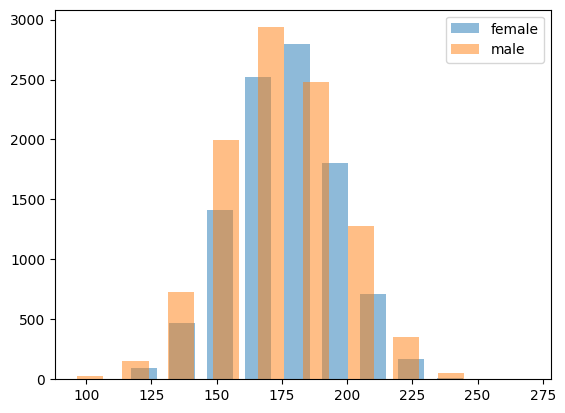

In [141]:
mu_female = np.random.normal(size=10_000, loc=178, scale=20)
mu_male = np.random.normal(size=10_000, loc=178, scale=20) + np.random.normal(size=10_000, loc=0, scale=10)
plt.hist(mu_female, alpha=0.5, width=10, label='female');
plt.hist(mu_male, alpha=0.5, width=10, label='male')
plt.legend()
;

def precis_df(data):
    # Gather the data
    mean_ = data.mean()
    std_ = data.std()
    quantile055 = data.quantile(0.055)
    quantile945 = data.quantile(0.945)
    
    precis_table = pd.concat([
        mean_, std_, quantile055, quantile945], axis=1)
    
    precis_table.columns = [
        'mean', 'std', '5.5%', '94.5%'
    ]
    return precis_table

precis_df(pd.DataFrame({'mu_female': mu_female, 'mu_male': mu_male}))

The prior for male in this case is wider, because it uses both parameters. Is there another way? We can use an <span style="color:blue">INDEX VARIABLE</span>.

### Code 5.47

In python, since we start indices by 0, we can keep the same as `d['male']`.

In [157]:
sex = d['male'].values

The new mathematical version will be:

$$ 
\begin{aligned}
h_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha_{SEX[i]} \\
\alpha_j &\sim \text{Normal}(178, 20) \quad \text{for j = 0..1} \\
\sigma &\sim \text{Uniform}(0, 50)
\end{aligned}
$$

### Code 5.48

Let's approximate the posterior for the above model.

In [168]:
with pm.Model() as m5_8:
    sigma = pm.Uniform('sigma', 0, 50)
    mu = pm.Normal('mu', 178, 20, shape=2)
    height = pm.Normal('height', mu[sex], sigma, observed=d['height'].values)
    m5_8_trace = pm.sample()
    
az.summary(m5_8_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],134.915,1.634,131.928,137.938,0.020,0.014,7018.0,3202.0,1.0
mu[1],142.602,1.701,139.624,145.992,0.021,0.015,6564.0,3140.0,1.0
sigma,27.415,0.835,25.982,29.098,0.010,0.007,6853.0,3025.0,1.0


In [170]:
with pm.Model() as m5_8:
    sigma = pm.Uniform('sigma', 0, 50)
    mu = pm.Normal('mu', 178, 20, shape=2)
    height = pm.Normal('height', mu[sex], sigma, observed=d['height'].values)
    m5_8_trace = pm.sample()

    # With PyMC it's easier just to create a deterministic that includes both values
    diff_fm = pm.Deterministic('diff', mu[0] - mu[1])

    m5_8_trace = pm.sample()

az.summary(m5_8_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],134.903,1.589,132.076,137.999,0.019,0.014,6823.0,3014.0,1.0
mu[1],142.566,1.688,139.505,145.869,0.021,0.015,6672.0,3119.0,1.0
sigma,27.429,0.832,25.910,28.999,0.010,0.007,7679.0,3323.0,1.0
diff,-7.662,2.323,-11.856,-3.171,0.028,0.020,7026.0,2923.0,1.0


We can now do the same to the milk data. For example let's check for clade.

### Code 5.50

In [172]:
d = pd.read_csv(DATA_PATH.joinpath('milk.csv'), delimiter=';')
d['clade'].unique()

array(['Strepsirrhine', 'New World Monkey', 'Old World Monkey', 'Ape'],
      dtype=object)

### Code 5.51

Convert the categories into integers.

In [173]:
d['clade_id'] = pd.Categorical(d['clade']).codes

Let's now use a model to measure the average milk energy in each clade.

$$ 
\begin{aligned}
K_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha_{CLADE[i]} \\
\alpha_j &\sim \text{Normal}(0, 0.5) \quad \text{for j = 1..4} \\
\sigma &\sim \text{Exponential}(1) \\
\end{aligned}
$$

### Code 5.52

Run the model.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


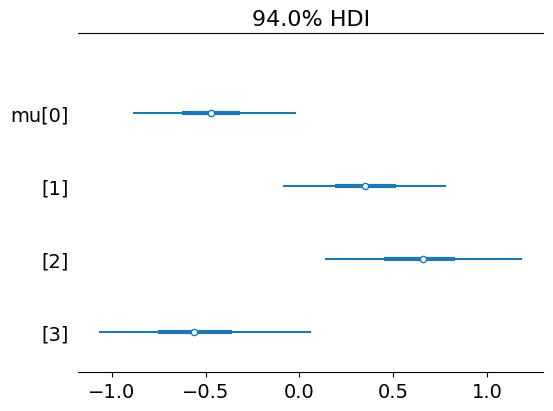

In [175]:
d['K'] = standardize(d['kcal.per.g'])

with pm.Model() as m5_9:
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Normal('mu', 0, 0.5, shape=4)
    K = pm.Normal('K', mu[d['clade_id'].values], sigma, observed=d['K'].values)
    m5_9_trace = pm.sample()

az.summary(m5_9_trace)

az.plot_forest(m5_9_trace, combined=True, var_names=["mu"]);